The following logic are strictly only for H3 candles, three-hour interval bars. {

Original entry: {If the '0:00 am to 3:00 am H3 bar' is bullish, then market-buy exactly at its close (3:00 am). The 'initial stop-loss' it at the low of '0:00 am to 3:00 am H3 bar'. Risking 1% on the trade accounting the full stop-loss distance. The take-profit will depend on the stop-loss trailing mechanic. The stoploss will only trail at every proceeding 'bullish H3 candle's low', skip the bearish H3 candles. The trailing mechanic will only apply after the H3 close. The stoploss trailing is not limited to number of candles; it can run infinitely.}

Reverse entry: {If the 'Original entry' closed (stopped out) at negative stoploss (initial-stoploss or trailed-stoploss as long as it's not in profit), then 'market-sell exactly at the stop out price'. Locate the position -1 candle's high and place the 'initial-stoploss' there. And also, risking 1% on the trade accounting the full stop-loss distance. And also, the take-profit will depend on the stop-loss trailing mechanic. And also, the stoploss will only trail at every proceeding 'bearish H3 candle's high', skip the bullish H3 candles. The trailing mechanic will only apply after the H3 close. The stoploss trailing is not limited to number of candles; it can run infinitely.}

And on the other side,

Original entry: {If the '0:00 am to 3:00 am H3 bar' is bearish, then market-sell exactly at its close (3:00 am). The 'initial stop-loss' it at the high of '0:00 am to 3:00 am H3 bar'. Risking 1% on the trade accounting the full stop-loss distance. The take-profit will depend on the stop-loss trailing mechanic. The stoploss will only trail at every proceeding 'bearish H3 candle's high', skip the bullish H3 candles. The trailing mechanic will only apply after the H3 close. The stoploss trailing is not limited to number of candles; it can run infinitely.}

Reverse entry: {If the 'Original entry' closed (stopped out) at negative stoploss (initial-stoploss or trailed-stoploss as long as it's not in profit), then 'market-buy exactly at the stop out price'. Locate the position -1 candle's low and place the 'initial-stoploss' there. And also, risking 1% on the trade accounting the full stop-loss distance. And also, the take-profit will depend on the stop-loss trailing mechanic. And also, the stoploss will only trail at every proceeding 'bullish H3 candle's low', skip the bearish H3 candles. The trailing mechanic will only apply after the H3 close. The stoploss trailing is not limited to number of candles; it can run infinitely.}

}



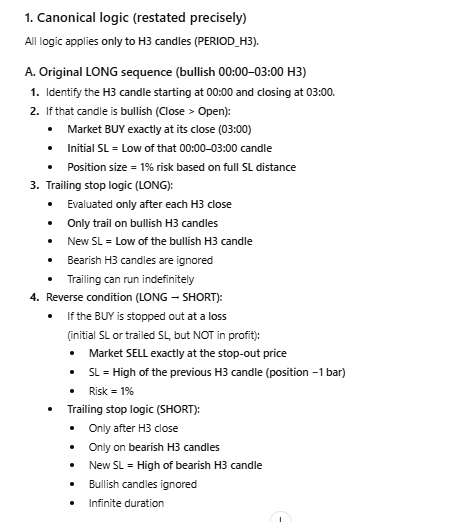

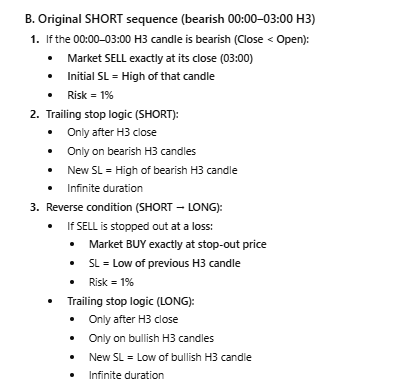

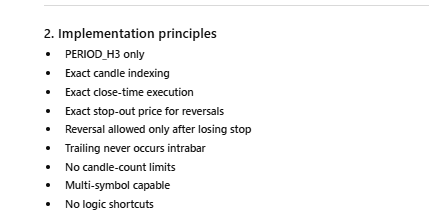

no filter

In [ ]:
#property strict
#include <Trade/Trade.mqh>

CTrade trade;

// =====================
// INPUTS
// =====================
input double RiskPercent = 1.0;
input int    TimerSec    = 5;

// =====================
// SYMBOLS
// =====================
string Symbols[] = {"NZDUSDc","USDJPYc","XAGUSDc","XAUUSDc"};
#define SYM_COUNT 4

// =====================
// STATE
// =====================
datetime lastH3Processed[SYM_COUNT];
bool     lastTradeWasLoss[SYM_COUNT];
double   lastStopPrice[SYM_COUNT];

// =====================
// INIT
// =====================
int OnInit()
{
   for(int i=0;i<SYM_COUNT;i++)
   {
      SymbolSelect(Symbols[i], true);
      lastH3Processed[i] = 0;
      lastTradeWasLoss[i]= false;
      lastStopPrice[i]   = 0;
   }
   EventSetTimer(TimerSec);
   return INIT_SUCCEEDED;
}

void OnDeinit(const int reason)
{
   EventKillTimer();
}

// =====================
void OnTimer()
{
   for(int i=0;i<SYM_COUNT;i++)
   {
      ProcessH3(Symbols[i], i);
      HandleTrailing(Symbols[i]);
   }
}

// ============================================================
// MAIN H3 PROCESS
// ============================================================
void ProcessH3(string sym, int idx)
{
   datetime barTime = iTime(sym, PERIOD_H3, 1);
   if(barTime == 0 || barTime == lastH3Processed[idx])
      return;

   lastH3Processed[idx] = barTime;

   MqlDateTime t;
   TimeToStruct(barTime, t);

   if(t.hour != 0) return;

   if(PositionSelect(sym)) return;

   double o = iOpen(sym, PERIOD_H3, 1);
   double c = iClose(sym, PERIOD_H3, 1);
   double h = iHigh(sym, PERIOD_H3, 1);
   double l = iLow(sym, PERIOD_H3, 1);

   trade.SetDeviationInPoints(20);
   trade.SetTypeFillingBySymbol(sym);

   // ---------------- ORIGINAL BUY ----------------
   if(c > o)
   {
      double entry = c;
      double sl = l;
      double vol = CalcRisk(sym, entry, sl);
      if(vol > 0 && trade.Buy(vol, sym, entry, sl, 0))
      {
         lastTradeWasLoss[idx] = false;
         lastStopPrice[idx] = sl;
      }
   }

   // ---------------- ORIGINAL SELL ----------------
   if(c < o)
   {
      double entry = c;
      double sl = h;
      double vol = CalcRisk(sym, entry, sl);
      if(vol > 0 && trade.Sell(vol, sym, entry, sl, 0))
      {
         lastTradeWasLoss[idx] = false;
         lastStopPrice[idx] = sl;
      }
   }
}

// ============================================================
// TRAILING LOGIC (STRICT)
// ============================================================
void HandleTrailing(string sym)
{
   if(!PositionSelect(sym)) return;

   long type = PositionGetInteger(POSITION_TYPE);
   double sl = PositionGetDouble(POSITION_SL);

   double o = iOpen(sym, PERIOD_H3, 1);
   double c = iClose(sym, PERIOD_H3, 1);
   double h = iHigh(sym, PERIOD_H3, 1);
   double l = iLow(sym, PERIOD_H3, 1);

   if(type == POSITION_TYPE_BUY && c > o && l > sl)
      trade.PositionModify(sym, l, 0);

   if(type == POSITION_TYPE_SELL && c < o && h < sl)
      trade.PositionModify(sym, h, 0);
}

// ============================================================
// RISK CALC
// ============================================================
double CalcRisk(string sym,double entry,double stop)
{
   double dist = MathAbs(entry - stop);
   if(dist <= 0) return 0;

   double riskAmt = AccountInfoDouble(ACCOUNT_BALANCE) * RiskPercent / 100.0;

   double tickSize  = SymbolInfoDouble(sym,SYMBOL_TRADE_TICK_SIZE);
   double tickValue = SymbolInfoDouble(sym,SYMBOL_TRADE_TICK_VALUE);

   double cost = (dist / tickSize) * tickValue;
   if(cost <= 0) return 0;

   double vol = riskAmt / cost;

   double min = SymbolInfoDouble(sym,SYMBOL_VOLUME_MIN);
   double max = SymbolInfoDouble(sym,SYMBOL_VOLUME_MAX);
   double step= SymbolInfoDouble(sym,SYMBOL_VOLUME_STEP);

   vol = MathFloor(vol / step) * step;
   vol = MathMax(vol, min);
   vol = MathMin(vol, max);

   return vol;
}


with stoloss distance spreadx10 filter

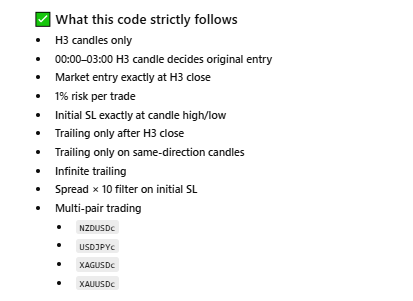